## Project 2

In This project we perform 2 tasks:

- 3D Object detection: where with a help of Deep Learning we detect objects based on the lidar information
- Multiple object detection: the goal is to track the number of annotated vehicles throughout the frames of the provided dataset.

### Environment preparation (MacOS)

- open the terminal
- create virtual environment: python -m venv venv
- activate virtual environment: source venv/bin/activate
- install all packages: pip install -r requirements.txt

We will be working in Python 3.9.5 version


### Part 1: Object Detection

#### Select a 3D object detection model suitable for your needs.

For out purpose we selected SFA3D model (https://github.com/maudzung/SFA3D) which is basically a Resnet model, because it has a very fast inference on cpu.

#### Configure the selected model to function within your local setup (this may vary depending on the model chosen).

For the inference we have used pretrained resnet model from the provided github repository:
- Number of Resnet layers: 18 (from pretrained model)
- number of classes: 3 (Cyclist, car pedestrian: from pretrained model)

BEV configs:
- image size: 608 by 608 (standard image, used in pretrained model)
- lim_x: [0,80] meters (detection in forward)
- lim_y: [-25,25] meters (detection in sides)
- lim_intensity: [0, 1.0] (lidar intensity)


In [1]:
from sfa.models import fpn_resnet
import torch
from tools.model_config import create_model_config
from tools.bev_tools import create_bev_config

# Define configs
bev_configs = create_bev_config()
models_config = create_model_config(model_name='fpn_resnet', configs=bev_configs)

# Create model
num_layers = 18
model = fpn_resnet.get_pose_net(num_layers=num_layers,
                                heads=models_config.heads,
                                head_conv=models_config.head_conv,
                                imagenet_pretrained=False)

# Load pre-trained weights
pretrained_path = './checkpoints/fpn_resnet_18/fpn_resnet_18_epoch_300.pth'
model.load_state_dict(torch.load(pretrained_path, map_location='cpu'))

# Put model to cpu
model = model.to(device='cpu')
model.eval()

student task ID_S3_EX1-3


PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

#### Extract point cloud information from the dataset provided.

In [11]:
import tools.dataset_tools as dataset_tools
from tools.frame_pb2 import Frame
import tools.plot_tools as plot_tools
import os

DATASET_PATH = './dataset'

# Read frame from file
frame = dataset_tools.read_frame(os.path.join(DATASET_PATH, "frame_194.pb"))

# Extract point cloud from frame
pcl = dataset_tools.decode_lidar(frame.lidars[0])

FileNotFoundError: [Errno 2] No such file or directory: './dataset\\frame_194.pb'

#### Calculate a Bird's Eye View perspective of the point cloud.

In [4]:
from tools import bev_tools
import numpy as np

# Calculate BEV from point cloud
lidar_bev = bev_tools.pcl_to_bev(pcl, bev_configs)

# Put BEV into torch tensor
lidar_bev_input = torch.Tensor(lidar_bev[np.newaxis, ...].copy())

#### Forward the Bird's Eye View perspective to the selected detection model.

In [5]:
from sfa.utils.torch_utils import _sigmoid
from sfa.utils.evaluation_utils import decode, post_processing, draw_predictions, get_labels

# BEV data to model
with torch.no_grad():
    outputs = model(lidar_bev_input)

#### Extract vehicle data from the perspective obtained.

In [6]:
import cv2

# Post-processing model output
outputs['hm_cen'] = _sigmoid(outputs['hm_cen'])
outputs['cen_offset'] = _sigmoid(outputs['cen_offset'])

# Detections
detections = decode(outputs['hm_cen'], outputs['cen_offset'], outputs['direction'], outputs['z_coor'], outputs['dim'], K = models_config.K)
detections = detections.cpu().numpy().astype(np.float32)
detections = post_processing(detections, models_config.num_classes, models_config.down_ratio, models_config.peak_thresh)

image_bev_map = (np.transpose(lidar_bev, (1, 2, 0)) * 255).astype(np.uint8)
image_bev_map = cv2.resize(image_bev_map, (bev_configs.bev_width, bev_configs.bev_height))   ### use same width, height as in BEV calculation
image_bev_map = draw_predictions(image_bev_map, detections[0].copy(), models_config.num_classes)

# Label detections
pred_labels = get_labels(detections)


#### Lidar detections

In [7]:
from PIL import Image, ImageDraw
from sfa.data_process.kitti_bev_utils import get_corners

# Draw bev map
img = Image.fromarray(image_bev_map)
draw = ImageDraw.Draw(img)

# Extract labels detection
labels_detections = []

for i in range(len(frame.lidars[0].detections)):
    detection = frame.lidars[0].detections[i]
    y, x, z = detection.pos
    l, w, h = detection.scale
    _, _, yaw = detection.rot

    x = (x - bev_configs.lim_x[0]) / (bev_configs.lim_y[1] - bev_configs.lim_y[0]) * bev_configs.bev_width
    y = (y - bev_configs.lim_x[0]) / (bev_configs.lim_x[1] - bev_configs.lim_x[0]) * bev_configs.bev_height
    
    x += bev_configs.bev_width / 2

    z = z - bev_configs.lim_z[0]
    w = w / (bev_configs.lim_y[1] - bev_configs.lim_y[0]) * bev_configs.bev_width
    l = l / (bev_configs.lim_x[1] - bev_configs.lim_x[0]) * bev_configs.bev_height
    yaw = -yaw
    
    label_box = get_corners(x, y, w , l, yaw)
    # Extract labels, which fit in the image size
    if np.all((label_box>= 0) & (label_box <= bev_configs.output_width)):
        labels_detections.append(label_box)
    
    draw.polygon(label_box, outline='red', width=3)

img.show()

#### Use performance measures to evaluate the model's effectiveness.

In [8]:
from sfa.utils.evaluation_utils import measure_detection_performance

ious, metrics = measure_detection_performance(pred_labels,labels_detections,0.5)
_, tp, fn, fp = metrics

print('ious:', ious)
print('True positives',tp)
print('False negatives',fn)
print('False positives',fp)

ious: [0.7021229425189699, 0.6351532226012253, 0.6431016676952667, 0.6253080547365353]
True positives 4
False negatives 8
False positives 0


#### Putting everything together

In [9]:
from tools.lidar_tools import label_extraction

# get all frames
files = os.listdir(DATASET_PATH)

# get bev for every frame
stacked_tensors_bev = []
labels = []
for file in files:
    labels_detections = []
    # get a frame 
    frame = dataset_tools.read_frame(os.path.join(DATASET_PATH, file))

    # convert a rame to pcl
    pcl = dataset_tools.decode_lidar(frame.lidars[0])

    # get a bev from pcl
    lidar_bev = bev_tools.pcl_to_bev(pcl, bev_configs)
    lidar_bev_input = torch.Tensor(lidar_bev[np.newaxis, ...].copy())

    # add to the all bevs
    stacked_tensors_bev.append(lidar_bev_input)

    # label extraciton from frame
    label = label_extraction(frame,bev_configs)
    labels.append(label)


#convert to tensor torch
stacked_tensors_bev = torch.cat(stacked_tensors_bev,0)

# model prediction
with torch.no_grad():
    outputs = model(stacked_tensors_bev)

#post-processing model output
outputs['hm_cen'] = _sigmoid(outputs['hm_cen'])
outputs['cen_offset'] = _sigmoid(outputs['cen_offset'])

# detections
detections = decode(outputs['hm_cen'], outputs['cen_offset'], outputs['direction'], outputs['z_coor'], outputs['dim'], K = models_config.K)
detections = detections.cpu().numpy().astype(np.float32)
detections = post_processing(detections, models_config.num_classes, models_config.down_ratio, models_config.peak_thresh)

# Convert labels into correct format:
pred_labels = []
for detect in detections:
    preds = get_labels([detect])
    pred_labels.append(preds)
    


# measure individual perfrmance: 
measurments_all = []
for pred, label in zip(pred_labels,labels):
    measurments = measure_detection_performance(pred,label)
    measurments_all.append(measurments)


# Calculate Performance overall:
ious = []
pos_neg = []

for item in measurments_all:
    ious.append(item[0])
    pos_neg.append(item[1])


pos_neg = np.array(pos_neg)
_ , tp, fn, fp = pos_neg.sum(axis=0)


precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Ious stats
ious_all = [iou for tupl in ious for iou in tupl]
std_iou = np.std(ious_all)
mean_iou = np.mean(ious_all)

#### Plots of the results

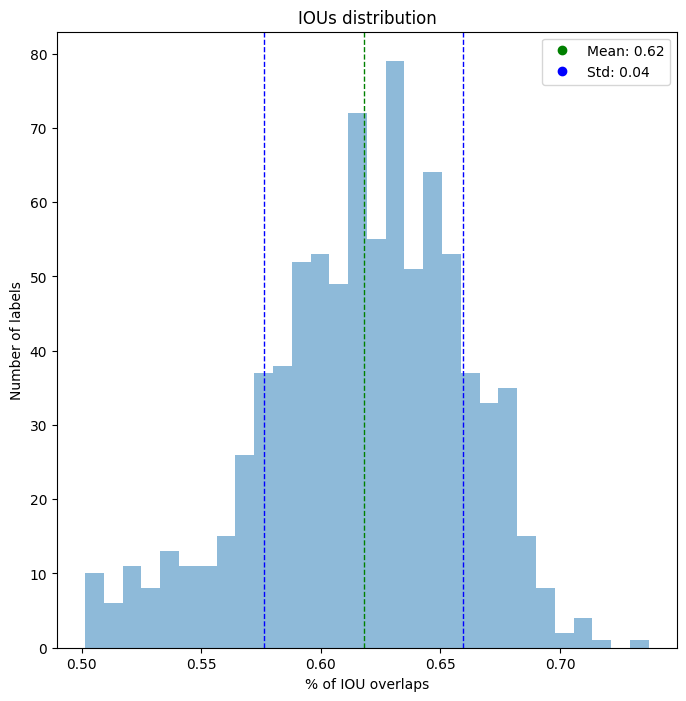

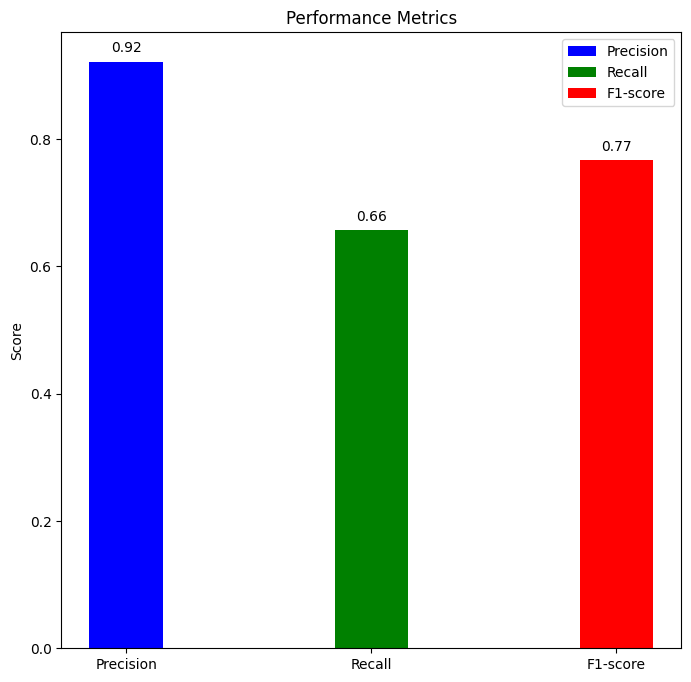

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Sample list of values

# Plot histogram

plt.figure(figsize=(8, 8))
plt.hist(ious_all, bins=30, alpha=0.5, label='Histogram')


# Mark mean and std on the plot
plt.axvline(mean_iou, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {mean_iou:.2f}')
plt.axvline(mean_iou + std_iou, color='blue', linestyle='dashed', linewidth=1, label=f'Std: {std_iou:.2f}')
plt.axvline(mean_iou - std_iou, color='blue', linestyle='dashed', linewidth=1)

# Create legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='o', color='green', label=f'Mean: {mean_iou:.2f}', linestyle='None'),
                  plt.Line2D([0], [0], marker='o', color='blue', label=f'Std: {std_iou:.2f}', linestyle='None')]

# Add legend with custom handles and labels
plt.legend(handles=legend_handles)

plt.title("IOUs distribution")
plt.xlabel("% of IOU overlaps")
plt.ylabel("Number of labels")

# Show plot
plt.show()


import matplotlib.pyplot as plt

# Example data
import matplotlib.pyplot as plt

# Example data
bar_width = 0.3
categories = ['Precision', 'Recall', 'F1-score']

plt.figure(figsize=(8, 8))  # Adjust size of the plot

plt.bar(categories[0], precision, color='blue', label='Precision', width=bar_width)
plt.bar(categories[1], recall, color='green', label='Recall', width=bar_width)
plt.bar(categories[2], f1_score, color='red', label='F1-score', width=bar_width)

# Annotate values on top of bars
plt.text(categories[0], precision + 0.01, f'{precision:.2f}', ha='center', va='bottom', color='black')
plt.text(categories[1], recall + 0.01, f'{recall:.2f}', ha='center', va='bottom', color='black')
plt.text(categories[2], f1_score + 0.01, f'{f1_score:.2f}', ha='center', va='bottom', color='black')

# Adding legend in the right corner
plt.legend(loc='upper right')

# Adding labels and title
plt.ylabel('Score')
plt.title('Performance Metrics')

# Show plot
plt.show()




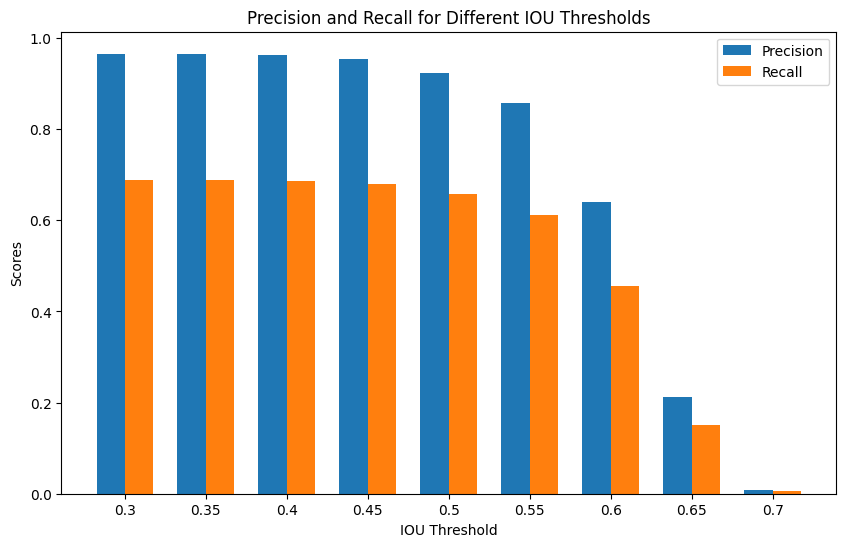

In [11]:
min_ious = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
all_metrics = []
for iou in min_ious:
    measurments_all = []
    for pred, label in zip(pred_labels,labels):
        measurments = measure_detection_performance(pred,label,iou)
        measurments_all.append(measurments)
    pos_neg = []
    for item in measurments_all:
        pos_neg.append(item[1])
    all_metrics.append(pos_neg)



prec_recall = []
for metric in all_metrics:
    metric = np.array(metric)
    _ , tp, fn, fp = metric.sum(axis=0)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    prec_recall.append((precision,recall))

precision = [pair[0] for pair in prec_recall]
recall = [pair[1] for pair in prec_recall]


# Plot bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(min_ious))
plt.bar(index, precision, bar_width, label='Precision', align='center')
plt.bar([i + bar_width for i in index], recall, bar_width, label='Recall', align='center')
plt.xlabel('IOU Threshold')
plt.ylabel('Scores')
plt.title('Precision and Recall for Different IOU Thresholds')
plt.xticks([i + bar_width/2 for i in index], min_ious)
plt.legend()
plt.show()

### Part 2: Multi-Object Tracking

In [3]:
import os

import cv2
from IPython.display import display
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import open3d as o3d
from PIL import Image
from scipy.spatial.transform import Rotation
from sympy import Matrix

import tools.dataset_tools as dataset_tools
from tools.frame_pb2 import Frame
import tools.plot_tools as plot_tools

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
def initialize_kalman_filter():
    # State transition matrix
    dt = 1  # time step
    A = np.array([[1, 0, 0, dt, 0, 0],
                  [0, 1, 0, 0, dt, 0],
                  [0, 0, 1, 0, 0, dt],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]])

    # Observation model
    H = np.array([[1, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0]])

    # Covariance matrices
    P = np.eye(6) * 100  # initial large uncertainty
    Q = np.eye(6) * 0.01  # process noise
    R = np.eye(3) * 1  # measurement noise

    # Initial state
    x = np.zeros(6)

    return x, A, H, P, Q, R

def kalman_filter(pcl, x, A, H, P, Q, R):
    """ Apply Kalman filter to a single point in the point cloud."""
    # Prediction step
    x_pred = A.dot(x)
    P_pred = A.dot(P).dot(A.T) + Q

    # Measurement update
    z = pcl[:3]  
    y = z - H.dot(x_pred)  
    S = H.dot(P_pred).dot(H.T) + R  #
    K = P_pred.dot(H.T).dot(np.linalg.inv(S))  
    x = x_pred + K.dot(y)
    P = (np.eye(len(x)) - K.dot(H)).dot(P_pred)

    return x, P

# Initialize Kalman filter
x, A, H, P, Q, R = initialize_kalman_filter()

for time_step in range(10):  
    pcl = np.random.rand(3) * 10  
    x, P = kalman_filter(pcl, x, A, H, P, Q, R)
    print("Filtered state:", x)

Filtered state: [0.2813128  6.25918534 5.22475035 0.14064937 3.1294362  2.61224456]
Filtered state: [ 5.75217437  6.54793816  0.61988067  5.31761773  0.3704226  -4.39737731]
Filtered state: [ 4.09658011  4.3229557   2.75125823  1.17202811 -1.17255133 -0.51601842]
Filtered state: [ 7.96480874  2.03796376  7.13570031  2.32766577 -1.6493624   1.58440277]
Filtered state: [ 5.38819301  4.4792412   8.87736982  0.66815624 -0.26517273  1.63761865]
Filtered state: [ 3.07255299  6.08066707  9.13932032 -0.18043549  0.26568796  1.24637859]
Filtered state: [4.92442078 7.96702726 8.96715866 0.33010691 0.67282301 0.89002186]
Filtered state: [5.65210273 6.88904015 8.06476325 0.42206008 0.26788675 0.47546249]
Filtered state: [ 5.67060786  5.57297082  8.02492693  0.33320977 -0.08085135  0.36200964]
Filtered state: [ 6.19825591  3.51638296  5.60124024  0.37497555 -0.50524394 -0.23636411]


In [5]:

class KalmanFilter:
    def __init__(self):
        self.dt = 1  # time step
        self.A = np.array([[1, 0, self.dt, 0], [0, 1, 0, self.dt], [0, 0, 1, 0], [0, 0, 0, 1]])  # State transition matrix
        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])  # Measurement matrix
        self.x = np.zeros(4)  # Initial state [x, y, vx, vy]
        self.P = np.eye(4) * 500  # Initial uncertainty
        self.Q = np.eye(4) * 0.1  # Process noise
        self.R = np.eye(2) * 5  # Measurement noise

    def predict(self):
        self.x = self.A.dot(self.x)
        self.P = self.A.dot(self.P).dot(self.A.T) + self.Q
        return self.x[:2]

    def update(self, z):
        y = z - self.H.dot(self.x)  
        S = self.H.dot(self.P).dot(self.H.T) + self.R  
        K = self.P.dot(self.H.T).dot(np.linalg.inv(S))  
        self.x += K.dot(y)
        self.P = (np.eye(4) - K.dot(self.H)).dot(self.P)


In [6]:
class Track:
    def __init__(self, initial_position):
        self.kf = KalmanFilter()
        self.kf.x[:2] = initial_position
        self.age = 0
        self.missed = 0

    def update(self, measurement):
        self.kf.update(measurement)
        self.age += 1
        self.missed = 0

    def predict(self):
        return self.kf.predict()

class Tracker:
    def __init__(self):
        self.tracks = []
        self.track_threshold = 3

    def update(self, detections):
        # Associate detections with existing tracks
        for track in self.tracks:
            prediction = track.predict()
            
            nearest_detection = min(detections, key=lambda d: np.linalg.norm(d - prediction))
            track.update(nearest_detection)
            detections.remove(nearest_detection)

        # Start new tracks for unassociated detections
        for detection in detections:
            self.tracks.append(Track(detection))

        # Optionally remove old tracks
        self.tracks = [track for track in self.tracks if track.missed < self.track_threshold]

# Simulated detection data
detections = [np.array([np.random.rand() * 10, np.random.rand() * 10]) for _ in range(5)]

# Tracker instance
tracker = Tracker()

# Update tracker with new detections
tracker.update(detections)

# Print track states
for track in tracker.tracks:
    print(f"Track position: {track.kf.x[:2]}, velocity: {track.kf.x[2:]}")


Track position: [4.70990334 3.9195374 ], velocity: [0. 0.]
Track position: [0.20350608 1.00637051], velocity: [0. 0.]
Track position: [0.43489004 7.52924647], velocity: [0. 0.]
Track position: [4.69273364 6.69114567], velocity: [0. 0.]
Track position: [5.20164544 5.9750866 ], velocity: [0. 0.]


In [7]:


def generate_synthetic_data(num_objects=3, num_steps=10, noise_level=1.0):
    """
    Generate synthetic data for multiple objects moving in a linear trajectory.

    Args:
    num_objects (int): Number of objects to simulate.
    num_steps (int): Number of time steps to simulate.
    noise_level (float): Standard deviation of the Gaussian noise added to measurements.

    Returns:
    dict: A dictionary containing the trajectory data for each object.
    """
    np.random.seed(42)  # For reproducibility
    initial_positions = np.random.rand(num_objects, 2) * 100  # Random initial positions
    velocities = np.random.rand(num_objects, 2) * 10 - 5  # Random velocities

    trajectories = {}
    for i in range(num_objects):
        trajectory = []
        current_position = initial_positions[i]
        for _ in range(num_steps):
            # Simulate motion
            current_position = current_position + velocities[i]
            # Add measurement noise
            measured_position = current_position + np.random.randn(2) * noise_level
            trajectory.append(measured_position)
        trajectories[i] = trajectory
    
    return trajectories

# Example of generating and using synthetic data
trajectories = generate_synthetic_data(num_objects=3, num_steps=10, noise_level=2.0)

# Print the generated trajectories
for obj_id, trajectory in trajectories.items():
    print(f"Object {obj_id}:")
    for step, pos in enumerate(trajectory):
        print(f"  Step {step}: Position = {pos}")


Object 0:
  Step 0: Position = [32.09589923 99.81831219]
  Step 1: Position = [ 27.68884874 101.46349405]
  Step 2: Position = [ 24.68044479 102.23015452]
  Step 3: Position = [ 16.32752071 108.59390141]
  Step 4: Position = [ 13.33253025 114.00873259]
  Step 5: Position = [  9.12298046 114.21739198]
  Step 6: Position = [  9.45116227 120.25220824]
  Step 7: Position = [  2.23575727 121.51602593]
  Step 8: Position = [ -3.40722847 128.24912894]
  Step 9: Position = [ -9.03961405 132.44044126]
Object 1:
  Step 0: Position = [73.00926692 61.3631867 ]
  Step 1: Position = [74.01828119 67.73185634]
  Step 2: Position = [76.20585008 63.9926039 ]
  Step 3: Position = [78.88908448 65.74706423]
  Step 4: Position = [78.67287196 66.35013706]
  Step 5: Position = [76.60992279 72.74392556]
  Step 6: Position = [81.75437816 74.77366543]
  Step 7: Position = [81.05729856 75.90944725]
  Step 8: Position = [79.34270126 77.152692  ]
  Step 9: Position = [82.38961781 82.78735065]
Object 2:
  Step 0: Po

In [8]:


# Initialize the tracker
tracker = Tracker()

# Simulate processing each time step
for step in range(10):
    # Extract detections for this time step
    detections = [trajectories[obj_id][step] for obj_id in trajectories]
    tracker.update(detections)

    # Print the state of each track
    print(f"After Step {step}:")
    for idx, track in enumerate(tracker.tracks):
        print(f"  Track {idx}: Position = {track.kf.x[:2]}, Velocity = {track.kf.x[2:]}")


After Step 0:
  Track 0: Position = [32.09589923 99.81831219], Velocity = [0. 0.]
  Track 1: Position = [73.00926692 61.3631867 ], Velocity = [0. 0.]
  Track 2: Position = [11.49494557 16.77247024], Velocity = [0. 0.]
After Step 1:
  Track 0: Position = [ 27.71077219 101.45530988], Velocity = [-2.19234429  0.818417  ]
  Track 1: Position = [74.01326172 67.70017457], Velocity = [0.50194721 3.16817712]
  Track 2: Position = [ 6.68576537 24.19039858], Velocity = [-2.40434967  3.70859331]
After Step 2:
  Track 0: Position = [ 24.69617162 102.23097227], Velocity = [-2.99081391  0.77689922]
  Track 1: Position = [76.17412101 64.12164436], Velocity = [ 2.11286943 -3.38335802]
  Track 2: Position = [-0.05157055 30.86340159], Velocity = [-6.61198907  6.58724705]
After Step 3:
  Track 0: Position = [ 17.25099547 107.63467605], Velocity = [-5.64063309  3.5293012 ]
  Track 1: Position = [78.78569372 64.88696379], Velocity = [ 2.40953895 -0.91538517]
  Track 2: Position = [-2.39724585 36.46313656],

In [ ]:

# Deserialize the protobuf data
def load_frame_data(filepath):
    frame = Frame()
    with open(filepath, "rb") as f:
        frame.ParseFromString(f.read())
    return frame

frame = load_frame_data(os.path.join(DATASET_PATH, "frame_194.pb"))

# Assuming a simple Kalman Filter Implementation
class SimpleKalmanFilter:
    def __init__(self):
        self.x = np.zeros(4)  # state: [x, y, dx, dy]
        self.P = np.eye(4) * 1000  # initial large uncertainty
        self.Q = np.eye(4)  # process noise
        self.R = np.eye(2) * 5  # measurement noise
        self.A = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]])  # state transition model
        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])  # measurement model

    def predict(self):
        self.x = np.dot(self.A, self.x)
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x += np.dot(K, y)
        self.P = self.P - np.dot(np.dot(K, self.H), self.P)

# Initialize the Kalman Filter
kf = SimpleKalmanFilter()

# Process each camera and lidar detection
for camera in frame.cameras:
    for detection in camera.detections:
        # Extract and preprocess camera detection data
        # Let's assume we extract the center of the bounding box
        x_center = detection.bbox[0] + detection.bbox[2] / 2
        y_center = detection.bbox[1] + detection.bbox[3] / 2
        kf.predict()
        kf.update(np.array([x_center, y_center]))

for lidar in frame.lidars:
    for detection in lidar.detections:
        # Extract and preprocess lidar detection data
        # Assuming direct x, y coordinates
        x_pos = detection.pos[0]
        y_pos = detection.pos[1]
        kf.predict()
        kf.update(np.array([x_pos, y_pos]))

# Output the state of the Kalman Filter
print("Estimated State:", kf.x)

In [ ]:
class Track:
    def __init__(self, initial_measurement):
        self.kf = SimpleKalmanFilter()
        self.kf.x[:2] = initial_measurement  # Initialize state with the first measurement
        self.time_since_update = 0  # Time since last update (for track pruning)

    def predict(self):
        self.kf.predict()

    def update(self, measurement):
        self.kf.update(measurement)
        self.time_since_update = 0  # Reset since we've just updated

    def increment_time_since_update(self):
        self.time_since_update += 1


In [ ]:
class Tracker:
    def __init__(self, max_time_since_update=5, max_distance=10):
        self.tracks = []
        self.max_time_since_update = max_time_since_update
        self.max_distance = max_distance

    def update(self, detections):
        # Predict for all tracks
        for track in self.tracks:
            track.predict()

        used_detections = set()

        # Update matched tracks with the nearest new detection
        for track in self.tracks:
            if detections:
                # Find the detection closest to the track's predicted state
                closest_detection = min(detections, key=lambda detection: np.linalg.norm(track.kf.x[:2] - detection))
                distance = np.linalg.norm(track.kf.x[:2] - closest_detection)

                if distance < self.max_distance:
                    track.update(closest_detection)
                    used_detections.add(tuple(closest_detection))

        # Remove detections that were used
        detections = [d for d in detections if tuple(d) not in used_detections]

        # Create new tracks for unmatched detections
        for detection in detections:
            self.tracks.append(Track(detection))

        # Increment the time since last update for all tracks and remove stale tracks
        self.tracks = [track for track in self.tracks if track.time_since_update < self.max_time_since_update]

    def get_states(self):
        return [track.kf.x for track in self.tracks]


In [ ]:
# Assume `load_frame_data` and other setup code has already been run
tracker = Tracker()

# Collect all detections into a single list
detections = []
for camera in frame.cameras:
    for detection in camera.detections:
        x_center = detection.bbox[0] + detection.bbox[2] / 2
        y_center = detection.bbox[1] + detection.bbox[3] / 2
        detections.append(np.array([x_center, y_center]))

for lidar in frame.lidars:
    for detection in lidar.detections:
        detections.append(np.array([detection.pos[0], detection.pos[1]]))

# Update the tracker with new detections
tracker.update(detections)

# Output the state of each track
for state in tracker.get_states():
    print("Track state:", state)


In [ ]:
class FusionTracker:
    def __init__(self):
        self.kalman_filter = KalmanFilter(state_vector_size=6, measurement_size=4)

    def update(self, camera_data, lidar_data):
        # Preprocess and extract features
        camera_features = extract_features(camera_data)  # Define this function
        lidar_features = extract_features(lidar_data)  # Define this function

        # Data association
        associated_data = associate_data(camera_features, lidar_features)  # Define this function

        # Sensor fusion using Kalman Filter
        for data in associated_data:
            self.kalman_filter.predict()
            self.kalman_filter.update(data)

    def get_state(self):
        return self.kalman_filter.get_state()
